In [20]:
import numpy as np
import pandas as pd
import matplotlib
import torch
import torch.nn as nn
import os
import shutil
from itertools import chain
from torchvision.transforms import Compose
import torch.nn.functional as F
import transformers
from collections import Counter

from PIL import Image
import time
from tqdm.notebook import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.transforms import RandomVerticalFlip,RandomHorizontalFlip,Normalize,ToTensor,Resize,RandomRotation,InterpolationMode
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader


In [ ]:
# data_path = Path.cwd()
# shutil.unpack_archive(data_path / Path("data.zip"), data_path)


In [5]:
class rellis_dataset(Dataset):
    """
    Using 6 classes
    """
    def __init__(self, data_root_dir, txt_file, transform=None, target_transform=None):
        """
        data_root_dit: root directory of the dataset, e.g. './data/rellis'
        txt_file: path to the train.txt listing image files
        
        """
        self.data_root_dir = data_root_dir
        self.transform = transform
        self.target_transform = target_transform
        with open(txt_file, 'r') as f:
            self.image_paths = [line.strip() for line in f.readlines()]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.data_root_dir, 'image', self.image_paths[index] + '.jpg')
        ann_path = os.path.join(self.data_root_dir, 'annotation', self.image_paths[index] + '_group6.png')
        image = Image.open(img_path).convert('RGB')
        annotation = Image.open(ann_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            annotation = self.target_transform(annotation)
        annotation = (annotation*256).long() # turn the label to the interger
        
        annotation=(nn.functional.one_hot(annotation,6))
        annotation = np.transpose(annotation, (0,3,1,2))
        # print(annotation.shape)
        return image, annotation

In [6]:
transform = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),
    # RandomHorizontalFlip(),
    # RandomVerticalFlip(),
    # RandomRotation(30),                
    ToTensor()
                       ])
target_transform = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),
    # RandomHorizontalFlip(),
    RandomVerticalFlip(),
    # RandomRotation(30),                
    ToTensor()
                       ])
example_dataset= rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/val.txt', transform=transform, target_transform=transform)
number_of_samples = len(example_dataset)


print(f"The number of samples is: {number_of_samples}")


The number of samples is: 983


In [7]:
# def display_image(axis, image_tensor,ann_tensor):
#     """Display a tensor as an image

#     Args:
#         axis (pyplot axis)
#         image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
#     """

#     # See hint above
#     if not isinstance(image_tensor, torch.Tensor):
#         raise TypeError(
#             "The `display_image` function expects a `torch.Tensor` "
#             + "use the `ToTensor` transformation to convert the images to tensors."
#         )

#     # The imshow commands expects a `numpy array` with shape (3, width, height)
#     # We rearrange the dimensions with `permute` and then convert it to `numpy`
#     image_data = image_tensor.permute(1, 2, 0).numpy()
#     ann_data = ann_tensor.permute(1, 2, 0).numpy()
#     height, width, _ = image_data.shape
#     axis.imshow(image_data)
#     axis.imshow(ann_data, alpha=0.6)
#     axis.set_xlim(0, width)
#     # By convention when working with images, the origin is at the top left corner.
#     # Therefore, we switch the order of the y limits.
#     axis.set_ylim(height, 0)


# # Example usage
# _, axis = plt.subplots()
# some_random_index = 453
# # Here we use the __getitem__ method as a "magic" method.
# # Implementing it for a class, enables square bracket '[]' indexing
# image_tensor,annotation = example_dataset[some_random_index]

# display_image(axis, image_tensor,annotation)
# print(nn.functional.one_hot(annotation,6).shape)
# print(image_tensor.shape)

dataset

In [8]:
NUM_GPUS = torch.cuda.device_count()
if NUM_GPUS > 1:
    model = torch.nn.DataParallel(model)

batch_size = 128

transforms_1 = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),
    # RandomHorizontalFlip(),
    # RandomVerticalFlip(),
    # RandomRotation(30),                
    ToTensor()
                       ])

transforms_2 = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),
    # RandomRotation(30),                
    ToTensor()
                       ])

train_dir = './train'
train_dataset= rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/train.txt', transform=transforms_1, target_transform=transforms_1)

val_dir = './val'
val_dataset= rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/val.txt', transform=transforms_2, target_transform=transforms_2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers = NUM_GPUS)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,num_workers = NUM_GPUS)

CNN Block

Encoder Block

Decoder block

model

In [9]:
class DownConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class DownConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class UpConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

class UpConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y


class ImageSegmentation(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.out_channels = 6
        self.bn_input = nn.BatchNorm2d(3)
        self.dc1 = DownConv2(3, 12, kernel_size=kernel_size)
        # self.dc2 = DownConv2(12, 24, kernel_size=kernel_size)
        # self.dc3 = DownConv3(20, 50, kernel_size=kernel_size)
        # self.dc4 = DownConv3(50, 100, kernel_size=kernel_size)
        self.dc5 = DownConv3(12, 12, kernel_size=kernel_size)

        self.uc5 = UpConv3(12, 12, kernel_size=kernel_size)
        # self.uc4 = UpConv3(100, 50, kernel_size=kernel_size)
        # self.uc3 = UpConv3(50, 20, kernel_size=kernel_size)
        # self.uc2 = UpConv2(24, 12, kernel_size=kernel_size)
        self.uc1 = UpConv2(12, 6, kernel_size=kernel_size)

    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        # x = batch
        # Encoder
        x, mp1_indices, shape1 = self.dc1(x)
        # x, mp2_indices, shape2 = self.dc2(x)
        # x, mp3_indices, shape3 = self.dc3(x)
        # x, mp4_indices, shape4 = self.dc4(x)
        x, mp5_indices, shape5 = self.dc5(x)

        # Decoder
        x = self.uc5(x, mp5_indices, output_size=shape5)
        # x = self.uc4(x, mp4_indices, output_size=shape4)
        # x = self.uc3(x, mp3_indices, output_size=shape3)
        # x = self.uc2(x, mp2_indices, output_size=shape2)
        x = self.uc1(x, mp1_indices, output_size=shape1)

        return x
    

model=ImageSegmentation(3)
model.uc1.seq[5] = nn.Softmax(dim=1)

trainning

In [10]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=6):
    with torch.no_grad():
        # pred_mask = F.softmax(pred_mask, dim=1)
        # pred_mask = torch.argmax(pred_mask, dim=1)
        # print(pred_mask.shape)
        # print(mask.shape)
        mask=torch.argmax(mask, dim=1).squeeze(0)
        pred_mask=torch.argmax(pred_mask, dim=1).squeeze(0)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        # print(pred_mask.shape)
        # print(mask.shape)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


def compute_accuracy(testDataLoader,loss_fn,model,device):

    model.eval()  
    total_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in testDataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn.calculate_average_dice_loss(outputs, labels.squeeze(1))
            # loss = loss_fn(torch.argmax(outputs, dim=1).float(), torch.argmax(labels.squeeze(1), dim=1).float())            
            # test_accuracy += pixel_accuracy(output, mask)
            val_accuracy += mIoU(outputs, labels.squeeze(1))
            total_loss += loss.item()

    return total_loss / len(testDataLoader), val_accuracy / len(testDataLoader)

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0
        # print(input.shape,target.shape)
        iflat = input.reshape(-1)
        tflat = target.reshape(-1)
        intersection = (iflat * tflat).sum()

        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

        return dice_loss

    def calculate_average_dice_loss(self, inputs, targets):
        num_channels = inputs.size(1)
        # print(num_channels)

        # Calculate Dice loss for each channel
        dice_losses = []
        for channel in range(num_channels):
            input_channel = inputs[:, channel, ...].unsqueeze(1)
            target_channel = targets[:, channel, ...].unsqueeze(1)
            # print(input_channel,target_channel)
            dice_loss_channel = self.forward(input_channel, target_channel)
            dice_losses.append(dice_loss_channel)

        # Calculate average Dice loss
        average_dice_loss = torch.mean(torch.stack(dice_losses))

        return average_dice_loss
    
dice_loss=DiceLoss()

def train(model, dataloader, loss_fn, optimizer, device, ldl): 
    model.train()  
    total_loss = 0
    train_accuracy = 0 

    for batch in tqdm(dataloader):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        # print(inputs.shape)
        # print(outputs.shape)
        optimizer.zero_grad() 
        outputs = model(inputs)
        # print(inputs.shape)
        # print(outputs.shape)
        # print(labels.squeeze(1).shape)

        loss = loss_fn.calculate_average_dice_loss(outputs, labels.squeeze(1))
        # loss = loss_fn(torch.argmax(outputs, dim=1).float(),torch.argmax(labels.squeeze(1), dim=1).float())
        train_accuracy += mIoU(outputs, labels.squeeze(1))
        # print(train_accuracy/ldl)

        loss.backward()     
        optimizer.step()   

        total_loss += loss.item()

    return total_loss / ldl, train_accuracy / ldl

In [11]:
import torch.optim as optim


ldl = len(train_dataloader)

num_epochs = 15
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model.parameters(), lr=0.001) #,weight_decay=0.0001


if(torch.cuda.is_available()):
    device = torch.device('cuda')
elif(torch.backends.mps.is_available()):
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model.to(device)

ImageSegmentation(
  (bn_input): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dc1): DownConv2(
    (seq): Sequential(
      (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dc5): DownConv3(
    (seq): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_ru

In [12]:

train_losses = []
cross_losses = []
train_acces=[]
val_acces=[]
bestScore=1

for epoch in range(num_epochs):
    train_loss,train_acc = train(model, train_dataloader,dice_loss, optimizer, device, ldl)
    Current_loss,val_acc = compute_accuracy(val_dataloader,dice_loss, model,device)
    #print(Current_loss)
    #print(CurrentScore)
    train_losses.append(train_loss)
    cross_losses.append(Current_loss)
    train_acces.append(train_acc)
    val_acces.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')
    print(f'Cross Acc: {Current_loss:.4f}')
    print(f'train Acc: {train_acc:.4f}')
    print(f'val Acc: {val_acc:.4f}')

    #scheduler.step()

    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve

    
    
    if Current_loss < bestScore:
        bestScore = Current_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')



  0%|          | 0/26 [00:00<?, ?it/s]

/Users/lewisliang/miniconda3/envs/dml/lib/python3.11/site-packages/torch/nn/functional.py:990: UserWarning: The operator 'aten::max_unpool2d' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1716905753263/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.max_unpool2d(input, indices, output_size)


Epoch 1/15, Train Loss: 0.7327
Cross Acc: 0.7627
train Acc: 0.2878
val Acc: 0.2647


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/15, Train Loss: 0.6432
Cross Acc: 0.6984
train Acc: 0.4265
val Acc: 0.3425


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/15, Train Loss: 0.5991
Cross Acc: 0.6517
train Acc: 0.4707
val Acc: 0.3704


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/15, Train Loss: 0.5575
Cross Acc: 0.5826
train Acc: 0.5005
val Acc: 0.4761


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5/15, Train Loss: 0.5315
Cross Acc: 0.5941
train Acc: 0.5431
val Acc: 0.4617


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6/15, Train Loss: 0.4928
Cross Acc: 0.5744
train Acc: 0.5909
val Acc: 0.4897


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7/15, Train Loss: 0.4672
Cross Acc: 0.5403
train Acc: 0.6260
val Acc: 0.5203


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8/15, Train Loss: 0.4488
Cross Acc: 0.5170
train Acc: 0.6508
val Acc: 0.5398


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9/15, Train Loss: 0.4333
Cross Acc: 0.5230
train Acc: 0.6638
val Acc: 0.5130


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10/15, Train Loss: 0.4218
Cross Acc: 0.4867
train Acc: 0.6674
val Acc: 0.5343


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11/15, Train Loss: 0.4073
Cross Acc: 0.4715
train Acc: 0.6780
val Acc: 0.5646


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12/15, Train Loss: 0.3946
Cross Acc: 0.5256
train Acc: 0.6874
val Acc: 0.4970


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13/15, Train Loss: 0.3852
Cross Acc: 0.4802
train Acc: 0.6890
val Acc: 0.5418


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14/15, Train Loss: 0.3727
Cross Acc: 0.4710
train Acc: 0.6997
val Acc: 0.5449


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15/15, Train Loss: 0.3614
Cross Acc: 0.4480
train Acc: 0.7051
val Acc: 0.5666


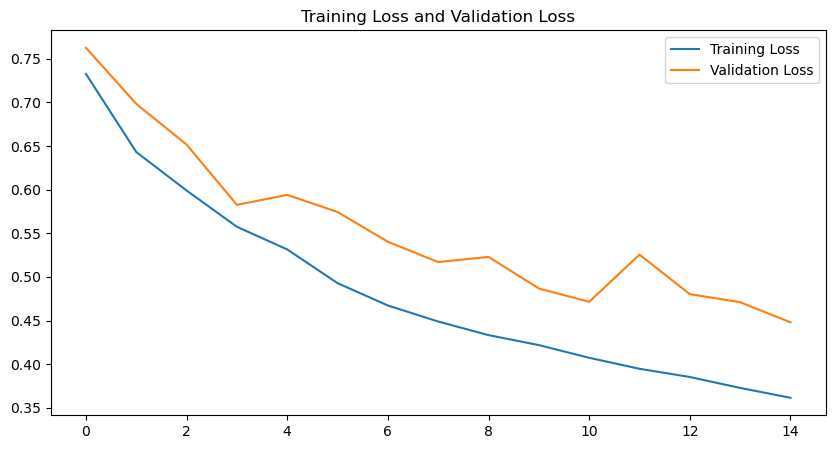

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(cross_losses, label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.legend()
plt.show(block=False)


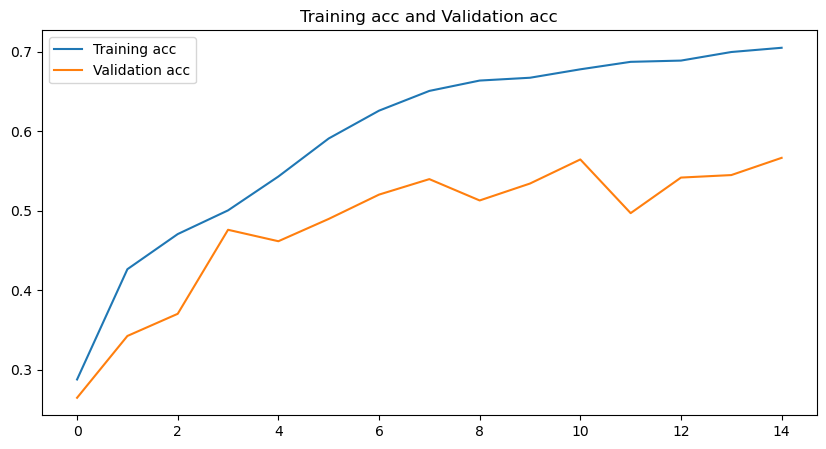

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_acces, label='Training acc')
plt.plot(val_acces, label='Validation acc')
plt.title('Training acc and Validation acc')
plt.legend()
plt.show(block=False)

torch.Size([3, 256, 256])
torch.Size([1, 6, 256, 256])
torch.Size([256, 256])


(-0.5, 255.5, 255.5, -0.5)

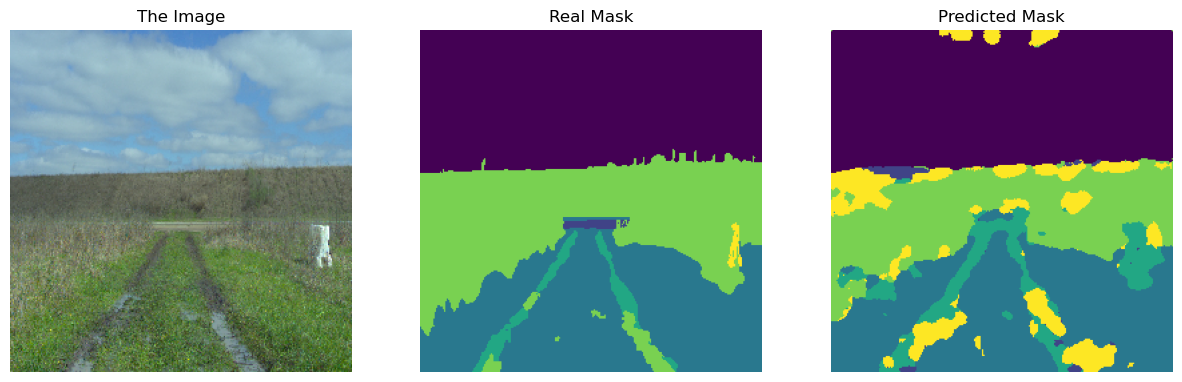

In [15]:


model = ImageSegmentation(3)
model.load_state_dict(torch.load('best_model.pt', map_location=device))
image_tensor,annotation = example_dataset[763]
print(image_tensor.shape)
image_tensor1 = image_tensor.unsqueeze(0).repeat(1, 1, 1, 1)

with torch.no_grad():
    pred = model(image_tensor1)
print(pred.shape)
pred = torch.argmax(pred, dim=1).squeeze(0)
print(pred.shape)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_tensor.permute(1, 2, 0))
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow((torch.argmax(annotation, dim=1).squeeze(0))/256)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred/256)
plt.title("Predicted Mask")
plt.axis('off')



Class Balance:
Class 0: 64963701
Class 5: 34011268
Class 4: 35665572
Class 2: 72680773
Class 3: 6781824
Class 1: 2296734


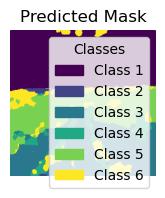

In [21]:
num_classes = model.out_channels  # Replace with appropriate way to get num_classes

# Create a colormap for the classes
cmap = matplotlib.colormaps['viridis']  # Choose a colormap with enough colors for your classes
norm = plt.Normalize(vmin=0, vmax=num_classes - 1)  # Normalize values to colormap range

# Get the predicted mask as numpy array
pred_np = pred.cpu().numpy()  # Move to CPU and remove extra dimension

# Create a new figure for the colormap legend
# fig_legend, ax_legend = plt.subplots(figsize=(4, 1))  # Adjust size as needed
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Set an empty array to avoid data plotting
# ax_legend.set_title('Colormap')
# plt.colorbar(sm, ax=ax_legend, label='Classes')  # Add labels for each color

# Loop through each class and create a legend patch with corresponding color
patches = []
for i in range(num_classes):
  color = cmap(norm(i))
  patch = plt.Rectangle((0, 0), 1, 1, color=color, label=f"Class {i+1}")
  patches.append(patch)


plt.subplot(1, 3, 3)
plt.imshow(pred_np/256)
plt.title("Predicted Mask")
plt.axis('off')

plt.legend(handles=patches, title="Classes")  # Add legend with class labels

# plt.tight_layout()  # Adjust spacing between subplots
# plt.show()
def get_class_balance(dataset):
        """
        Calculates the pixel count for each class in the dataset.

        Returns:
            Counter: A Counter object containing the class labels and their corresponding pixel counts.
        """
        class_counts = Counter()
        for image, annotation in dataset:
            # Convert one-hot encoded annotation to integer labels
            labels = torch.argmax(annotation, dim=1).flatten()

            # Count pixels for each class
            class_counts.update(labels.tolist())

        return class_counts
class_counts = get_class_balance(train_dataset)

# Print the class labels and their pixel counts
print("Class Balance:")
for class_label, pixel_count in class_counts.items():
    print(f"Class {class_label}: {pixel_count}")
